#### 1. Read the Data
Let's read the data using the SQL module available in SPARK. Then, we might need to inspect the data


In [0]:
# This will create the sql context to read data and save the data as df - Estamos creando el contexto de SQL para leer y gudar los datos en la variable df
from pyspark.sql import SQLContext
sqlcontext = SQLContext(sc)
df = sqlcontext.sql('select * from train')

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
# Function to drop the empty columns of a DF
def dropColumns(tn):
    for col in tn.columns:
        # Get the distinct values of the column
        unique_val = df.filter(df[col]!='null').select(col).distinct().count()
        # See whether the unique value is only none/nan or null
        if unique_val == 1:
            print("Dropping " + col + " because of all null values.")
            tn = tn.drop(col)
    return(tn)

  
df = dropColumns(df) # drops the columns w/ all null values if they exist

#### 2. Define Target  - NA for Clustering

In [0]:
df.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217.0,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183.0,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27.0,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203.0,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39.0,0


In [0]:
df.columns

Out[4]: ['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [0]:
df = df.drop('id')

#### 3. Check Data Set

In [0]:
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: string (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Previously_Insured: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: string (nullable = true)
 |-- Vintage: double (nullable = true)
 |-- Response: string (nullable = true)



In [0]:
summary = df.describe().toPandas()
#summary.index = summary.summary
#summary = summary[df.columns]
summary.T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Gender,381109,None,None,Female,Male
Age,381109,38.822583565331705,15.511611018095321,20,85
Driving_License,381109,0.9978693759528114,0.04610954420779957,0,1
Region_Code,381109,26.388807401557035,13.229888025788474,0.0,9.0
Previously_Insured,381109,0.4582101183650871,0.498251198887226,0,1
Vehicle_Age,381109,None,None,1-2 Year,> 2 Years
Vehicle_Damage,381109,None,None,No,Yes
Annual_Premium,381109,30564.389581458323,17213.155056980126,2630.0,540165.0
Policy_Sales_Channel,381109,112.03429465061177,54.20399477485638,1.0,99.0


In [0]:
# have a summary dataframe that gives key descriptive statistics
import pandas as pd
null_list = [df.where(df[x].isNull()).count() for x in df.columns]
null_list.insert(0, 'null_count') # insert null-count at index 0
null_list = pd.DataFrame(null_list).T # make null_count a pandas dataframe and transpose it
null_list.columns = summary.columns
summary = summary.append(null_list) # merge it w/ summary dataframe defned above
summary.index = summary.summary
summary = summary[df.columns]
summary.T

<command-427077659987398>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(null_list) # merge it w/ summary dataframe defned above


summary,count,mean,stddev,min,max,null_count
Gender,381109,None,None,Female,Male,0
Age,381109,38.822583565331705,15.511611018095321,20,85,0
Driving_License,381109,0.9978693759528114,0.04610954420779957,0,1,0
Region_Code,381109,26.388807401557035,13.229888025788474,0.0,9.0,0
Previously_Insured,381109,0.4582101183650871,0.498251198887226,0,1,0
Vehicle_Age,381109,None,None,1-2 Year,> 2 Years,0
Vehicle_Damage,381109,None,None,No,Yes,0
Annual_Premium,381109,30564.389581458323,17213.155056980126,2630.0,540165.0,0
Policy_Sales_Channel,381109,112.03429465061177,54.20399477485638,1.0,99.0,0
Vintage,381109,154.34739667654136,83.6713036265871,10.0,299.0,0


#### 4. Determine Categorical and Numerical Variables

In [0]:
# identify categorical variables
dtypes = df.dtypes # this will identify the data types of the variables in spark_df
cat_input = [] # create an empty list
for i in range(0, len(df.columns)): #iterate over the variables
  if dtypes[i][1] == 'string': # if dtype is string save it in the cat_input list
    cat_input.append(dtypes[i][0])
cat_input

Out[9]: ['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel',
 'Response']

In [0]:
# numerical variables
num_input = list(set(df.columns) - set(cat_input)) # the difference of the categorical variables from all the variables will give us the numerical variables. 
num_input

Out[10]: ['Age', 'Vintage', 'Annual_Premium']

#### 5. Create an imputer for numerical data

In [0]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when 

class NumericImputer(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(NumericImputer, self).__init__()  # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol)  # do not change this part at all when creating custom transformers

        
    def setParams(self, inputCol=None, outputCol=None):  # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol)  # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):  # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      
      
      from pyspark.sql.functions import when  
      from pyspark.sql.types import DoubleType
      median_v = dataset.approxQuantile(in_col, [0.5], 0)[0] # compute median #dataset = dataset.fillna(median_v, subset=in_col)
      return dataset.withColumn(out_col, when(col(in_col).isNull(), median_v).otherwise(col(in_col)).cast(DoubleType())) # replacing null values with median if the value is null otherwise keeping it as is

In [0]:
numericimputers = [] # creating an empty list
for column in num_input: # creating a list of numeric imputers each of which responsible for imputing a variable
  numericimputers.append(NumericImputer(inputCol = column , outputCol = column))
numericimputers

Out[12]: [NumericImputer_cab974da919d,
 NumericImputer_fdaf54810753,
 NumericImputer_9a2f16374ce0]

#### 6. Create an imputer for categorical data

In [0]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col

class CategoricalImputer(Transformer, HasInputCol, HasOutputCol): # replacing missing values in categorical columns

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(CategoricalImputer, self).__init__()  # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol)  # do not change this part at all when creating custom transformers

        
    def setParams(self, inputCol=None, outputCol=None):  # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol)  # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):  # do not change this part at all when creating custom transformers
      
      from pyspark.sql.functions import when

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      
      #Groupby column name in_col
      temp = dataset.groupby(in_col).count() # groupby and count the levels (such as how many observations there are for each level)
      temp = temp.filter(temp[in_col]!= 'null') # exclude the null in case the domintaing level is null
      #sort it and convert to pandas
      sorted_df = temp.sort(temp['count'].desc()).toPandas() # sort it find the most occuring level (which is the mode)
      #mode 
      mode_v = sorted_df.loc[0][in_col] # get the mode
      
      return dataset.withColumn(out_col, when(col(in_col).isNull(), mode_v).otherwise(col(in_col))) # repace the nulls with the mode for that variable

In [0]:
cat_imputers = []
for column in cat_input:
  cat_imputers.append(CategoricalImputer(inputCol = column, outputCol = column))
cat_imputers

Out[14]: [CategoricalImputer_fe7b48ecdfb2,
 CategoricalImputer_ead17f3d1ce5,
 CategoricalImputer_6d8cf822abdf,
 CategoricalImputer_b843f36199f7,
 CategoricalImputer_08fa80e0740f,
 CategoricalImputer_4f491f4b4c05,
 CategoricalImputer_b2e3ab0b9173,
 CategoricalImputer_4e42ba14c7a5]

#### 7. Standardize variables

In [0]:
# normalize a dataset
from pyspark.sql.types import IntegerType
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


class Standardizer(Transformer, HasInputCol, HasOutputCol): # creating a standardizer class that will standardize columns (x-mean/3std)
  
    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(Standardizer, self).__init__() # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol) # do not change this part at all when creating custom transformers

        
        
    def setParams(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol) # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset): # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      from pyspark.sql.functions import stddev, mean, col 
      from pyspark.sql.types import DoubleType
      from pyspark.sql.functions import udf

      mean_ = dataset.select(mean(in_col)).first()[0] # compute mean
      std_ = dataset.select(stddev(in_col)).first()[0] # compute stdev
      udf_c =  udf(lambda x: (x-mean_)/std_, DoubleType()) # create a custom udf that will iteratre over a column and subtract the mean fom each value and divide the result by stdev
      return dataset.withColumn(out_col, udf_c(dataset[in_col])) # standardize the variable and saves the variable as out_col

In [0]:
standardizers = [] # creating an empty list
for column in num_input: # creating a list of numeric imputers each of which responsible for imputing a variable
  standardizers.append(Standardizer(inputCol = column, outputCol = column+"_standardized"))
standardizers

Out[16]: [Standardizer_a4451ada65bc,
 Standardizer_bb68a610a8c5,
 Standardizer_7d059baf972c]

#### 8. Encode categorical variables

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

indexers = [StringIndexer(inputCol = column, outputCol = column+"_index", handleInvalid='keep') for column in cat_input] # this will first create indexers (it means it will number each category in a variable)
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy", handleInvalid='keep') for column in cat_input] # This will use the numbers to create the binary variables
encoders

Out[17]: [OneHotEncoder_88014c5e5fd7,
 OneHotEncoder_00888b7b9c08,
 OneHotEncoder_9906904cc245,
 OneHotEncoder_d06167333fc5,
 OneHotEncoder_6da4f6089e55,
 OneHotEncoder_4bf6ee82299e,
 OneHotEncoder_154d243e854b,
 OneHotEncoder_9ef5d12c1d07]

#### 9. Determine the variables

In [0]:
input_cols = [] # creates an empty list
for i in cat_input: #iterates over categorical variables
  input_cols.append(i+"_dummy") # saves the name of the dummy encoded categorical variables (they are not categorical now though)
for i in num_input: # iterates over the numerical variables
  input_cols.append(i+"_standardized") # saves the name of standardized numerical variables
input_cols

Out[18]: ['Gender_dummy',
 'Driving_License_dummy',
 'Region_Code_dummy',
 'Previously_Insured_dummy',
 'Vehicle_Age_dummy',
 'Vehicle_Damage_dummy',
 'Policy_Sales_Channel_dummy',
 'Response_dummy',
 'Age_standardized',
 'Vintage_standardized',
 'Annual_Premium_standardized']

#### 10. Add more stages to the Pipeline

In [0]:
# your code goes in here
from pyspark.ml.feature import StringIndexer
import functools 
import operator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

stages = []
assembler = VectorAssembler(inputCols= input_cols, outputCol="features") #conactenates all input variables and names as features [[0,1,0],30,20,40000]
stages = functools.reduce(operator.concat, [numericimputers, cat_imputers, indexers, encoders, standardizers]) #indexers,  encoders, standardizers])
stages.append(assembler)
stages

Out[19]: [NumericImputer_cab974da919d,
 NumericImputer_fdaf54810753,
 NumericImputer_9a2f16374ce0,
 CategoricalImputer_fe7b48ecdfb2,
 CategoricalImputer_ead17f3d1ce5,
 CategoricalImputer_6d8cf822abdf,
 CategoricalImputer_b843f36199f7,
 CategoricalImputer_08fa80e0740f,
 CategoricalImputer_4f491f4b4c05,
 CategoricalImputer_b2e3ab0b9173,
 CategoricalImputer_4e42ba14c7a5,
 StringIndexer_950b94fae7b8,
 StringIndexer_fce40fa37256,
 StringIndexer_c1d905dc85ca,
 StringIndexer_d8f8712a9fad,
 StringIndexer_64a93c04a6e3,
 StringIndexer_c40f8152ac45,
 StringIndexer_b2fec285627c,
 StringIndexer_7f7d9efa4a5f,
 OneHotEncoder_88014c5e5fd7,
 OneHotEncoder_00888b7b9c08,
 OneHotEncoder_9906904cc245,
 OneHotEncoder_d06167333fc5,
 OneHotEncoder_6da4f6089e55,
 OneHotEncoder_4bf6ee82299e,
 OneHotEncoder_154d243e854b,
 OneHotEncoder_9ef5d12c1d07,
 Standardizer_a4451ada65bc,
 Standardizer_bb68a610a8c5,
 Standardizer_7d059baf972c,
 VectorAssembler_261eae0ec931]

#### 11. Combine the stages as a list

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
df2 = pipeline.fit(df).transform(df)

In [0]:
from pyspark.ml.clustering import KMeans # import K-means
kmeans = KMeans().setK(2).setSeed(1) # 2 clusters here
model = kmeans.fit(df2.select('features')) # train k-means

In [0]:
transformed = model.transform(df2) # find the clusters (similar to making predictions)
transformed.select('features', 'prediction').show() # display features and predictions

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(232,[0,3,6,60,65...|         0|
|(232,[0,3,14,60,6...|         0|
|(232,[0,3,6,60,65...|         0|
|(232,[0,3,15,61,6...|         1|
|(232,[1,3,9,61,64...|         1|
|(232,[1,3,17,60,6...|         1|
|(232,[0,3,15,60,6...|         1|
|(232,[1,3,6,60,63...|         0|
|(232,[1,3,14,61,6...|         1|
|(232,[1,3,20,61,6...|         1|
|(232,[1,3,19,60,6...|         0|
|(232,[1,3,13,61,6...|         1|
|(232,[1,3,10,61,6...|         0|
|(232,[0,3,6,60,63...|         0|
|(232,[0,3,6,61,63...|         0|
|(232,[0,3,20,60,6...|         0|
|(232,[1,3,21,60,6...|         1|
|(232,[1,3,19,61,6...|         1|
|(232,[0,3,6,60,63...|         0|
|(232,[1,3,17,60,6...|         0|
+--------------------+----------+
only showing top 20 rows



In [0]:
transformed.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|170630|
|         0|210479|
+----------+------+



In [0]:
transformed.crosstab('prediction', 'Vehicle_Age').show()

+----------------------+--------+--------+---------+
|prediction_Vehicle_Age|1-2 Year|< 1 Year|> 2 Years|
+----------------------+--------+--------+---------+
|                     0|  192758|    1739|    15982|
|                     1|    7558|  163047|       25|
+----------------------+--------+--------+---------+



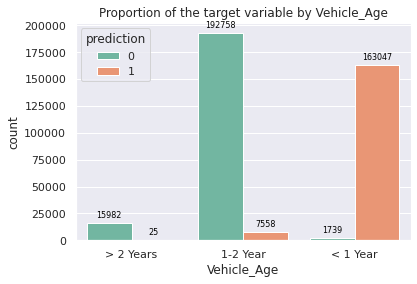

In [0]:
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz
sns.set(style="darkgrid") 
pandas_df = transformed.select('Vehicle_Age', 'prediction').toPandas()
ax = sns.countplot(x='Vehicle_Age', hue = 'prediction', data = pandas_df, palette = "Set2")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=8,
                color="black",
                xytext=(0, 8),
                textcoords="offset points")
ax.set_title('Proportion of the target variable by Vehicle_Age')

display()

In [0]:
transformed.crosstab('prediction', 'Gender').show()

+-----------------+------+------+
|prediction_Gender|Female|  Male|
+-----------------+------+------+
|                0| 79546|130933|
|                1| 95474| 75156|
+-----------------+------+------+



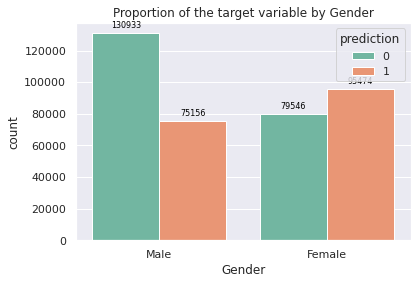

In [0]:
sns.set(style="darkgrid") 
pandas_df = transformed.select('Gender', 'prediction').toPandas()
ax = sns.countplot(x='Gender', hue = 'prediction', data = pandas_df, palette = "Set2")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=8,
                color="black",
                xytext=(0, 8),
                textcoords="offset points")
ax.set_title('Proportion of the target variable by Gender')

display()

In [0]:
transformed.crosstab('prediction', 'Driving_License').show()

+--------------------------+---+------+
|prediction_Driving_License|  0|     1|
+--------------------------+---+------+
|                         0|811|209668|
|                         1|  1|170629|
+--------------------------+---+------+



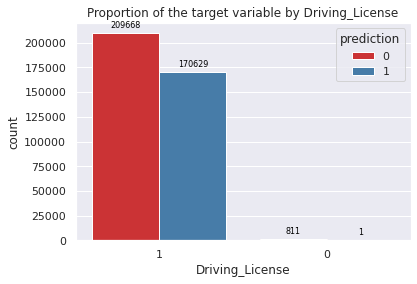

In [0]:
sns.set(style="darkgrid") 
pandas_df = transformed.select('Driving_License', 'prediction').toPandas()
ax = sns.countplot(x='Driving_License', hue = 'prediction', data = pandas_df, palette = "Set1")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=8,
                color="black",
                xytext=(0, 8),
                textcoords="offset points")
ax.set_title('Proportion of the target variable by Driving_License')

display()

In [0]:
transformed.crosstab('prediction', 'Vehicle_Damage').show()

+-------------------------+------+------+
|prediction_Vehicle_Damage|    No|   Yes|
+-------------------------+------+------+
|                        0| 65230|145249|
|                        1|123466| 47164|
+-------------------------+------+------+



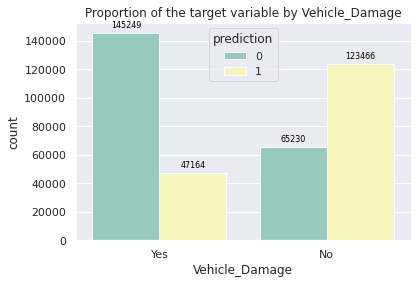

In [0]:
sns.set(style="darkgrid") 
pandas_df = transformed.select('Vehicle_Damage', 'prediction').toPandas()
ax = sns.countplot(x='Vehicle_Damage', hue = 'prediction', data = pandas_df, palette = "Set3")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=8,
                color="black",
                xytext=(0, 8),
                textcoords="offset points")
ax.set_title('Proportion of the target variable by Vehicle_Damage')

display()

In [0]:
transformed.crosstab('prediction', 'Response').show()

+-------------------+------+-----+
|prediction_Response|     0|    1|
+-------------------+------+-----+
|                  0|169992|40487|
|                  1|164407| 6223|
+-------------------+------+-----+



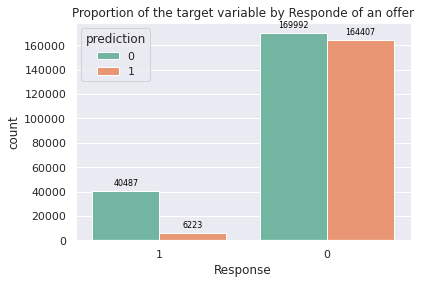

In [0]:
sns.set(style="darkgrid") 
pandas_df = transformed.select('Response', 'prediction').toPandas()
ax = sns.countplot(x='Response', hue = 'prediction', data = pandas_df, palette = "Set2")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=8,
                color="black",
                xytext=(0, 8),
                textcoords="offset points")
ax.set_title('Proportion of the target variable by Responde of an offer')

display()

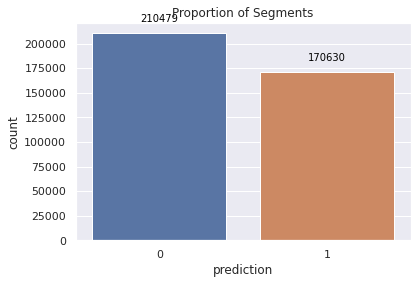

In [0]:
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

sns.set(style="darkgrid") 
pandas_df = transformed.select('Age', 'prediction').toPandas()
ax = sns.countplot(x='prediction', data = pandas_df)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                xytext=(0, 10),
                textcoords="offset points")
                 
#bar_container= ax.bar(df['churn'].value_counts().index, df['churn'].value_counts().values)
#ax.bar_label(bar_container, fmt='{:,.0f}') #crear etiquetas en las barras
ax.set_title('Proportion of Segments')

display()

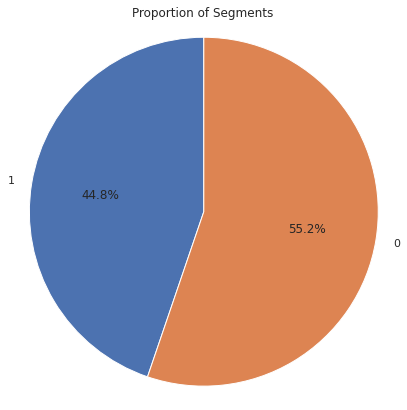

In [0]:
prediction_counts = transformed.groupBy("prediction").count()
# Collect the counts as a list
counts = [row["count"] for row in prediction_counts.collect()]
# Get the categories as a list
categories = [row["prediction"] for row in prediction_counts.collect()]
# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Segments')
# Show the pie chart
plt.show()

In [0]:
transformed.groupBy('prediction').mean().toPandas() # analyze the clusters

,prediction,avg(Age),avg(Annual_Premium),avg(Vintage),avg(Gender_index),avg(Driving_License_index),avg(Region_Code_index),avg(Previously_Insured_index),avg(Vehicle_Age_index),avg(Vehicle_Damage_index),avg(Policy_Sales_Channel_index),avg(Response_index),avg(Age_standardized),avg(Vintage_standardized),avg(Annual_Premium_standardized),avg(prediction)
0,1,25.054193,29828.315126,154.613749,0.559538,0.000006,11.978779,0.681264,0.955852,0.723589,1.195224,0.036471,-0.887618,0.003183,-0.042762,1.0
1,0,49.984269,31161.106519,154.131472,0.377928,0.003853,8.106091,0.277386,0.160125,0.309912,5.487526,0.192356,0.719570,-0.002581,0.034666,0.0


In [0]:
transformed.select('Driving_License_index').show()

+---------------------+
|Driving_License_index|
+---------------------+
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
|                  0.0|
+---------------------+
only showing top 20 rows



In [0]:
a = transformed.select('Gender','Age','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel','Vintage','prediction').show()

+------+----+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+----------+
|Gender| Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|prediction|
+------+----+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+----------+
|  Male|44.0|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|  217.0|         0|
|  Male|76.0|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|  183.0|         0|
|  Male|47.0|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|   27.0|         0|
|  Male|21.0|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|  203.0|         1|

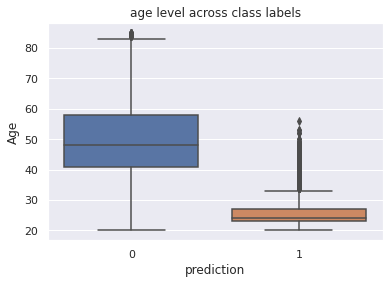

In [0]:
## using seaborn or matplotlib in Jupyter Notebook
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

fig, ax = plt.subplots() # creates figure and axes space
sns.set_style("whitegrid") # sets the backgropund to white with grids

pandas_df = transformed.select('Age', 'prediction').toPandas() # selects age and class variables and save it as a pandas df

ax = sns.boxplot(x='prediction', y='Age', data = pandas_df) #  create sa box plot

ax.set_title('age level across class labels') # sets the title of the boxplot

display()

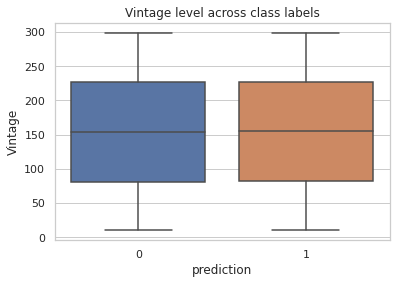

In [0]:
## using seaborn or matplotlib in Jupyter Notebook
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

fig, ax = plt.subplots() # creates figure and axes space
sns.set_style("whitegrid") # sets the backgropund to white with grids

pandas_df = transformed.select('Vintage', 'prediction').toPandas() # selects age and class variables and save it as a pandas df

ax = sns.boxplot(x='prediction', y='Vintage', data = pandas_df) #  create sa box plot

ax.set_title('Vintage level across class labels') # sets the title of the boxplot

display()

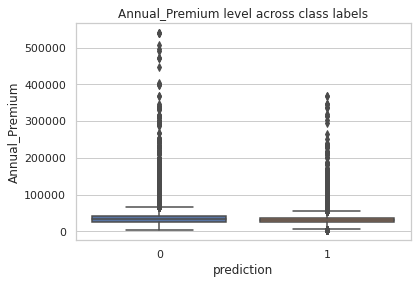

In [0]:
## using seaborn or matplotlib in Jupyter Notebook
import matplotlib.pyplot as plt # imports matplotlib for data viz
import numpy as np # imports numpy as np
import seaborn as sns # imports seaborn for data viz

fig, ax = plt.subplots() # creates figure and axes space
sns.set_style("whitegrid") # sets the backgropund to white with grids

pandas_df = transformed.select('Annual_Premium', 'prediction').toPandas() # selects age and class variables and save it as a pandas df

ax = sns.boxplot(x='prediction', y='Annual_Premium', data = pandas_df) #  create sa box plot

ax.set_title('Annual_Premium level across class labels') # sets the title of the boxplot

display()

In [0]:
transformed.columns

Out[42]: ['Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_index',
 'Driving_License_index',
 'Region_Code_index',
 'Previously_Insured_index',
 'Vehicle_Age_index',
 'Vehicle_Damage_index',
 'Policy_Sales_Channel_index',
 'Response_index',
 'Gender_dummy',
 'Driving_License_dummy',
 'Region_Code_dummy',
 'Previously_Insured_dummy',
 'Vehicle_Age_dummy',
 'Vehicle_Damage_dummy',
 'Policy_Sales_Channel_dummy',
 'Response_dummy',
 'Age_standardized',
 'Vintage_standardized',
 'Annual_Premium_standardized',
 'features',
 'prediction']

In [0]:
from pyspark.sql import functions as F
transformed.filter(transformed["prediction"] == 0).agg(F.min("Age")).show()

+--------+
|min(Age)|
+--------+
|    20.0|
+--------+



In [0]:
from pyspark.sql import functions as F
transformed.filter(transformed["prediction"] == 0).agg(F.max("Age")).show()

+--------+
|max(Age)|
+--------+
|    85.0|
+--------+



In [0]:
from pyspark.sql import functions as F
transformed.filter(transformed["prediction"] == 1).agg(F.min("Age")).show()

+--------+
|min(Age)|
+--------+
|    20.0|
+--------+



In [0]:
from pyspark.sql import functions as F
transformed.filter(transformed["prediction"] == 1).agg(F.max("Age")).show()

+--------+
|max(Age)|
+--------+
|    56.0|
+--------+



In [0]:
filtered_df = transformed.filter(transformed["prediction"] == 0)
# Calculate the 0.25 and 0.75 quantiles for the "Age" column
quantiles = filtered_df.approxQuantile("Age", [0.25, 0.75], 0.0)
# Display the quantiles
print("25th Percentile (0.25 Quantile):", quantiles[0])
print("75th Percentile (0.75 Quantile):", quantiles[1])

25th Percentile (0.25 Quantile): 41.0
75th Percentile (0.75 Quantile): 58.0


In [0]:
filtered_df = transformed.filter(transformed["prediction"] == 1)
# Calculate the 0.25 and 0.75 quantiles for the "Age" column
quantiles = filtered_df.approxQuantile("Age", [0.25, 0.75], 0.0)
# Display the quantiles
print("25th Percentile (0.25 Quantile):", quantiles[0])
print("75th Percentile (0.75 Quantile):", quantiles[1])

25th Percentile (0.25 Quantile): 23.0
75th Percentile (0.75 Quantile): 27.0


In [0]:
transformed.select('Gender').where('prediction ==0 and Response ==1 ').groupBy('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|15118|
|  Male|25369|
+------+-----+



In [0]:
transformed.select('Age').where('prediction ==0 and Response ==1 ').agg(F.mean("Age")).show()

+------------------+
|          avg(Age)|
+------------------+
|46.166275594635316|
+------------------+



/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


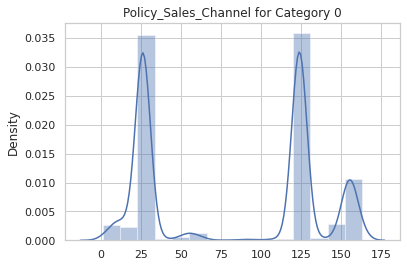

In [0]:
from pyspark.sql.functions import col
df = transformed.withColumn("Policy_Sales_Channel", col("Policy_Sales_Channel").cast("float"))
premiun = df.select('Policy_Sales_Channel').where('prediction ==0').toPandas()
# Create a distribution plot
ax = sns.distplot(premiun, bins=15)
ax.set_title('Policy_Sales_Channel for Category 0')
# Display the plot
plt.show()
# Calculate the average Annual_Premium


/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


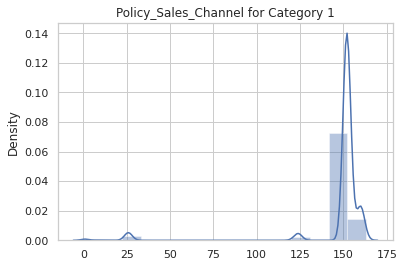

In [0]:
from pyspark.sql.functions import col
df = transformed.withColumn("Policy_Sales_Channel", col("Policy_Sales_Channel").cast("float"))
premiun = df.select('Policy_Sales_Channel').where('prediction ==1').toPandas()
# Create a distribution plot
ax = sns.distplot(premiun, bins=15)
ax.set_title('Policy_Sales_Channel for Category 1')
# Display the plot
plt.show()


/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


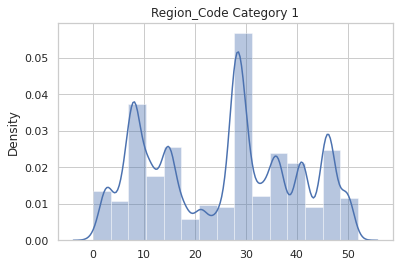

In [0]:
from pyspark.sql.functions import col
df = transformed.withColumn("Region_Code", col("Region_Code").cast("float"))
premiun = df.select('Region_Code').where('prediction ==1').toPandas()
# Create a distribution plot
ax = sns.distplot(premiun, bins=15)
ax.set_title('Region_Code Category 1')
# Display the plot
plt.show()

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


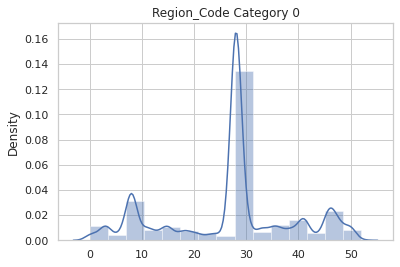

In [0]:
from pyspark.sql.functions import col
df = transformed.withColumn("Region_Code", col("Region_Code").cast("float"))
premiun = df.select('Region_Code').where('prediction ==0').toPandas()
# Create a distribution plot
ax = sns.distplot(premiun, bins=15)
ax.set_title('Region_Code Category 0')
# Display the plot
plt.show()